### Benchmark on the entire dataset

#### Baseline result in one file

In [1]:
import os
import re
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm

def extract_info(text):
    line = text
    if "Start Time: " in line and  "End Time: " in line and  "Transcript: " in line and "Latency: " in line:
        start_time = float(line.split("Start Time: ")[1].split(",")[0])
        end_time = float(line.split("End Time: ")[1].split(",")[0])
        transcript = line.split("Transcript: ")[1].split(", Latency: ")[0]  # Keep spaces as they are
        latency = float(line.split("Latency: ")[1])
        
        return start_time, end_time, transcript, latency
    else:
        return None
    

In [2]:
def process_log(file_path):
    df = pd.DataFrame(columns=['audio', 'start_time', 'end_time', 'transcript', 'latency'])
    with open(file_path, errors="ignore") as f:
        audio = None
        start_and_end_time_set = set()
        for line in tqdm(f.readlines()):
            if line.strip().endswith(".wav"):
                audio = line.strip()
                start_and_end_time_set = set()
                continue
            elif (ret := extract_info(line)) is not None:
                start_time, end_time, transcript, latency = ret
                #print(transcript)
                #if (start_time, end_time) in start_and_end_time_set:
                #    continue
                #else:
                start_and_end_time_set.add((start_time, end_time))
                df_new = pd.DataFrame([{
                    'audio': audio,
                    'start_time': start_time,
                    'end_time': end_time,
                    'transcript': transcript,
                    'latency': latency}]
                )
                df = pd.concat([df, df_new], ignore_index=True)
    
    return df

In [3]:
result_dir = "benchmarking_results"
exp_name = "fig1"
model_type = "medium"
log_file = "baseline_medium_ted-long-form-test-cut_step-100_ct-8_gt-3_mdr-0.5_no_tag.log"

file_path = os.path.join(result_dir, exp_name, model_type, log_file)

df = process_log(file_path)

  0%|          | 0/2092353 [00:00<?, ?it/s]/var/folders/q8/v4sscjhd6szcgb36c6hggw5w0000gq/T/ipykernel_23912/2119370464.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_new], ignore_index=True)
100%|██████████| 2092353/2092353 [00:07<00:00, 265360.21it/s]


In [4]:
print(df.latency.min())
print(df.latency.mean())

-0.27
3.210989990100099


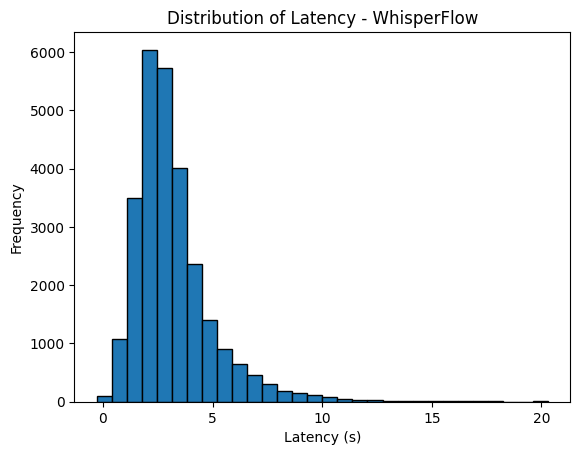

In [5]:
plt.hist(df.latency, bins=30, edgecolor='black')  # 'bins' controls the number of intervals
plt.xlabel('Latency (s)')
plt.ylabel('Frequency')
plt.title('Distribution of Latency - WhisperFlow')
plt.show()

In [6]:
final_res = ''
for i in df['transcript']:
    final_res += i
print(final_res[:200])
print(len(final_res))

 i'd like to share with you a discovery that i made a few months ago while writing an article for italian wired i always keep my thesaurus handy whenever i'm writing anything but i'd already finished 
134531


In [7]:
with open("tmp.txt", "w") as file:
    file.write(final_res)

In [8]:
import subprocess
command = [
    "python", 
    "wer/main.py", 
    "tmp.txt", 
    "samples/ted-lium-long-form-test-combined-transcript.txt", 
    "True"
]

result = subprocess.run(command, capture_output=True, text=True)
print("Output:", result.stdout)
print("Errors:", result.stderr)

Output: Average length of predictions and references: 
27389.0
27848.0

Normalisation: True
Word Error Rate: 0.043753294675803904
Accuracy: 95.6%


Errors: /Users/rxpwang/miniconda3/lib/python3.12/site-packages/whisper/__init__.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full contr